In [1]:
using Flux
using Distributions
using Random
using Dates

# Core

In [2]:
const LOG_STD_MAX = 2
const LOG_STD_MIN = -20

-20

## SquashedGaussianMLPActor

In [3]:
function mlp(sizes, activation, output_activation=identity)
    layers = []
    for j = 1:length(sizes)-1
        act = j < length(sizes)-1 ? activation : output_activation
        push!(layers, Dense(sizes[j], sizes[j+1], act))
    end
    Chain(layers...)
end

mlp (generic function with 2 methods)

In [4]:
struct SquashedGaussianMLPActor
    net
    mu_layer
    log_std_layer
    act_mins
    act_maxs
end

In [5]:
function SquashedGaussianMLPActor(obs_dim, act_dim, hidden_sizes, activation, act_mins, act_maxs)
    net = mlp(vcat(obs_dim,hidden_sizes), activation, activation)
    mu_layer = Dense(hidden_sizes[end], act_dim)
    log_std_layer = Dense(hidden_sizes[end], act_dim)
    SquashedGaussianMLPActor(net, mu_layer, log_std_layer, act_mins, act_maxs)
end

SquashedGaussianMLPActor

In [6]:
#assumes independent multivariate normal, all inputs are (dims,batch_size)
function normal_logpdf(μ, σ, x)
    lz = sum(((x.-μ)./σ).^2; dims=1) ./ -2.0
    den = (2π)^(size(μ,1)/2) .* sqrt.(prod(σ.^2; dims=1))
    lpdf = lz .- log.(den)
    lpdf = dropdims(lpdf; dims=1)
    lpdf
end

normal_logpdf (generic function with 1 method)

In [7]:
#forward function
#obs is (obs_dim, batch_size); original code had (batch_size, obs_dim)
function (ac::SquashedGaussianMLPActor)(obs, deterministic=false, with_logprob=true; rng=Random.GLOBAL_RNG)
    net_out = ac.net(obs)
    mu = ac.mu_layer(net_out)
    log_std = ac.log_std_layer(net_out)
    log_std = clamp.(log_std, LOG_STD_MIN, LOG_STD_MAX)
    std = exp.(log_std)

    # Pre-squash distribution and sample
    if deterministic
        # only used for evaluating policy at test time
        pi_action = mu
    else
        pi_action = mu .+ std .* randn(rng, size(mu)) 
    end

    if with_logprob
        logp_pi = normal_logpdf(mu, std, pi_action)
        logp_pi = logp_pi .- dropdims(sum((2*(log(2) .- pi_action .- softplus.(-2 .* pi_action))); dims=1); dims=1)
    else
        logp_pi = NaN
    end
    
    pi_action = tanh.(pi_action)
    pi_action = ac.act_mins .+ (ac.act_maxs .- ac.act_mins) .* (pi_action ./ 2 .+ 0.5) #changed: original assumes all actions have the same symmetrical bounds
    
    pi_action, logp_pi  #NaN if with_logprob=false
end

In [8]:
mu = rand(2,3)
sig = rand(2,3)
x = mu .+ sig .* randn(size(mu))

2×3 Array{Float64,2}:
 0.849625  -0.0329471   1.43105
 0.261708   0.611437   -0.963861

In [9]:
lp = normal_logpdf(mu, sig, x)

3-element Array{Float64,1}:
  0.07973620407767079
 -0.3748107838848487
 -3.7150920661161413

In [10]:
net = mlp([2,10,15,20,2], relu, identity)

Chain(Dense(2, 10, relu), Dense(10, 15, relu), Dense(15, 20, relu), Dense(20, 2))

In [11]:
ac = SquashedGaussianMLPActor(2, 2, [20,20], relu, [0.0, 0.0], [1.0,360.0])
dump(ac)

SquashedGaussianMLPActor
  net: Chain{Tuple{Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}}}
    layers: Tuple{Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}}
      1: Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}
        W: Array{Float32}((20, 2)) Float32[-0.27376458 -0.19614863; -0.4571975 0.4626447; … ; -0.14770426 0.5102979; -0.21268319 0.39180967]
        b: Array{Float32}((20,)) Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        σ: relu (function of type typeof(relu))
      2: Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}
        W: Array{Float32}((20, 20)) Float32[-0.17873788 0.023879636 … -0.108528756 0.21698686; -0.080733016 0.3715911 … -0.32921252 -0.19849263; … ; -0.2982138 -0.37813175 … -0.37171325 0.2316529; 0.23265553 -0.0022865012 … -0.040586 0.08649562]
        b: Array{

In [12]:
pi_action,logp_pi=(ac)(rand(2,3))

([0.35300886983833224 0.9952278994723491 0.7751990417426845; 44.12165070090995 51.27207492131603 340.8935812332805], [-1.5600156682723263, -0.19226502917766197, -1.3219427108409412])

In [13]:
pi_action

2×3 Array{Float64,2}:
  0.353009   0.995228    0.775199
 44.1217    51.2721    340.894

In [14]:
logp_pi

3-element Array{Float64,1}:
 -1.5600156682723263
 -0.19226502917766197
 -1.3219427108409412

## MLPQFunction

In [15]:
struct MLPQFunction
    q
end

In [16]:
function MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)
    q = mlp(vcat(obs_dim+act_dim, hidden_sizes, 1), activation)
    MLPQFunction(q)
end

MLPQFunction

In [17]:
#forward function
#obs is (obs_dim, batch_size); original code had (batch_size, obs_dim)
function (qf::MLPQFunction)(obs, act)
    q = qf.q(cat(obs,act; dims=1))
    q = dropdims(q; dims=1)
    q
end

In [18]:
qf = MLPQFunction(2,2,[10,15,10], relu)
dump(qf)

MLPQFunction
  q: Chain{Tuple{Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}}}
    layers: Tuple{Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}}
      1: Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}
        W: Array{Float32}((10, 4)) Float32[-0.14422798 -0.01867485 -0.36851802 -0.15441184; -0.27869946 -0.010968478 -0.46020004 -0.59988105; … ; 0.22282927 0.1924547 0.2855616 0.15919918; -0.16813797 -0.14234313 -0.05918895 0.43870276]
        b: Array{Float32}((10,)) Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        σ: relu (function of type typeof(relu))
      2: Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}
       

In [19]:
q = qf(rand(2), rand(2))

0-dimensional Array{Float32,0}:
-0.08890161

In [20]:
q = qf(rand(2,3), rand(2,3))

3-element Array{Float32,1}:
  0.10797873
 -0.123976246
 -0.02132627

## MLPActorCritic

In [21]:
struct MLPActorCritic
    pi
    q1
    q2
end

In [22]:
#TODO: use framework calls for obs_dim, act_dim, act_mins, act_maxs
function MLPActorCritic(obs_dim, act_dim, act_mins, act_maxs, hidden_sizes=[256,256], activation=relu)
    pi = SquashedGaussianMLPActor(obs_dim, act_dim, hidden_sizes, activation, act_mins, act_maxs)
    q1 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)
    q2 = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation)
    MLPActorCritic(pi, q1, q2)
end

MLPActorCritic

In [23]:
#act function
function (ac::MLPActorCritic)(obs, deterministic=false)
    a,_ = ac.pi(obs, deterministic, false)
    a
end

In [24]:
ac = MLPActorCritic(2, 2, [0.0,0.0], [1.0,360.0])
dump(ac;maxdepth=3)

MLPActorCritic
  pi: SquashedGaussianMLPActor
    net: Chain{Tuple{Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}}}
      layers: Tuple{Dense{typeof(relu),Array{Float32,2},Array{Float32,1}},Dense{typeof(relu),Array{Float32,2},Array{Float32,1}}}
    mu_layer: Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}
      W: Array{Float32}((2, 256)) Float32[0.06279945 0.15225446 … 0.059213553 -0.063058354; -0.066516116 0.0049990746 … -0.021819605 0.042717084]
      b: Array{Float32}((2,)) Float32[0.0, 0.0]
      σ: identity (function of type typeof(identity))
    log_std_layer: Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}
      W: Array{Float32}((2, 256)) Float32[0.08633091 -0.14974326 … -0.060397312 -0.0988582; 0.099551335 0.0365805 … -0.056436416 0.050152216]
      b: Array{Float32}((2,)) Float32[0.0, 0.0]
      σ: identity (function of type typeof(identity))
    act_mins: Array{Float64}((2,)) [0.0, 0.0]
    act

In [25]:
(ac)(rand(2,3))

2×3 Array{Float64,2}:
   0.945561    0.650193    0.0723085
 344.251     169.66      109.793

# SAC

## Replay buffer

In [26]:
mutable struct ReplayBuffer
    obs_buf
    act_buf
    rew_buf
    obs2_buf
    done_buf
    ptr
    size
    max_size
end

In [27]:
#size is second dim; original code had it as first dim
function ReplayBuffer(obs_dim, act_dim, max_size)
    obs_buf = zeros(Float32, obs_dim, max_size)
    act_buf = zeros(Float32, act_dim, max_size) 
    rew_buf = zeros(Float32, max_size)
    obs2_buf = zeros(Float32, obs_dim, max_size)
    done_buf = zeros(Float32, max_size)
    ptr = 1
    size = 0
    ReplayBuffer(obs_buf, act_buf, rew_buf, obs2_buf, done_buf, ptr, size, max_size)
end

ReplayBuffer

In [28]:
function store!(buf::ReplayBuffer, obs, act, rew, next_obs, done)
    buf.obs_buf[:,buf.ptr] = obs
    buf.act_buf[:,buf.ptr] = act
    buf.rew_buf[buf.ptr] = rew
    buf.obs2_buf[:,buf.ptr] = next_obs
    buf.done_buf[buf.ptr] = done
    buf.ptr = mod1(buf.ptr+1, buf.max_size)
    buf.size = min(buf.size+1, buf.max_size)
    buf.size
end

store! (generic function with 1 method)

In [29]:
function sample_batch(buf::ReplayBuffer, batch_size=32)
    idxs = rand(1:buf.size, batch_size)
    batch = (obs=buf.obs_buf[:,idxs], 
        act=buf.act_buf[:,idxs],
        rew=buf.rew_buf[idxs],
        obs2=buf.obs2_buf[:,idxs],
        done=buf.done_buf[idxs])
    batch
end

sample_batch (generic function with 2 methods)

In [30]:
function sample_batch_nz(buf::ReplayBuffer, batch_size=32)
    nzids = findall(x->x != 0.0, buf.rew_buf)
    n = min(batch_size, length(nzids))
    idxs = rand(nzids,n)
    batch = (obs=buf.obs_buf[:,idxs], 
        act=buf.act_buf[:,idxs],
        rew=buf.rew_buf[idxs],
        obs2=buf.obs2_buf[:,idxs],
        done=buf.done_buf[idxs])
    batch
end

sample_batch_nz (generic function with 2 methods)

In [31]:
buf = ReplayBuffer(2,2,10)

ReplayBuffer(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1, 0, 10)

In [32]:
store!(buf, [1.0,1.0], [2.0,2.0], 1.0, [1.0,0.0], 0.0)

1

In [33]:
dump(buf)

ReplayBuffer
  obs_buf: Array{Float32}((2, 10)) Float32[1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0]
  act_buf: Array{Float32}((2, 10)) Float32[2.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0]
  rew_buf: Array{Float32}((10,)) Float32[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  obs2_buf: Array{Float32}((2, 10)) Float32[1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  done_buf: Array{Float32}((10,)) Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  ptr: Int64 2
  size: Int64 1
  max_size: Int64 10


In [34]:
for i=1:4
    store!(buf, rand(2), rand(2), rand(), rand(2), rand())
end
dump(buf)

ReplayBuffer
  obs_buf: Array{Float32}((2, 10)) Float32[1.0 0.6004594 … 0.0 0.0; 1.0 0.77626395 … 0.0 0.0]
  act_buf: Array{Float32}((2, 10)) Float32[2.0 0.08138227 … 0.0 0.0; 2.0 0.23820437 … 0.0 0.0]
  rew_buf: Array{Float32}((10,)) Float32[1.0, 0.47086784, 0.028610239, 0.12327904, 0.708602, 0.0, 0.0, 0.0, 0.0, 0.0]
  obs2_buf: Array{Float32}((2, 10)) Float32[1.0 0.34123832 … 0.0 0.0; 0.0 0.94136494 … 0.0 0.0]
  done_buf: Array{Float32}((10,)) Float32[0.0, 0.49345362, 0.41399074, 0.08294672, 0.41584072, 0.0, 0.0, 0.0, 0.0, 0.0]
  ptr: Int64 6
  size: Int64 5
  max_size: Int64 10


In [35]:
obs,obs2,act,rew,done=sample_batch(buf, 3)

(obs = Float32[0.039531805 0.6004594 0.6004594; 0.99975204 0.77626395 0.77626395], act = Float32[0.1494759 0.08138227 0.08138227; 0.78441435 0.23820437 0.23820437], rew = Float32[0.028610239, 0.47086784, 0.47086784], obs2 = Float32[0.26001206 0.34123832 0.34123832; 0.73196584 0.94136494 0.94136494], done = Float32[0.41399074, 0.49345362, 0.49345362])

In [36]:
obs

2×3 Array{Float32,2}:
 0.0395318  0.600459  0.600459
 0.999752   0.776264  0.776264

In [37]:
obs2

2×3 Array{Float32,2}:
 0.149476  0.0813823  0.0813823
 0.784414  0.238204   0.238204

In [38]:
act

3-element Array{Float32,1}:
 0.028610239
 0.47086784
 0.47086784

In [39]:
rew

2×3 Array{Float32,2}:
 0.260012  0.341238  0.341238
 0.731966  0.941365  0.941365

In [40]:
done

3-element Array{Float32,1}:
 0.41399074
 0.49345362
 0.49345362

## sac support functions

In [41]:
#data is a namedtuple, each component is (batch_size, dim)
function compute_loss_q(ac, ac_targ, data, gamma, alpha)
    o, a, r, o2, d = data
    
    q1 = ac.q1(o,a)
    q2 = ac.q2(o,a)
    
    a2, logp_a2 = ac.pi(o2)
    
    #target q-values
    q1_pi_targ = ac_targ.q1(o2, a2)
    q2_pi_targ = ac_targ.q2(o2, a2)
    q_pi_targ = min(q1_pi_targ, q2_pi_targ)
    backup = r .+ gamma .* (1.0 .- d) .* (q_pi_targ .- alpha[] .* logp_a2)
    
    #MSE loss against Bellman backup
    loss_q1 = mean((q1 .- backup).^2)
    loss_q2 = mean((q2 .- backup).^2)
    loss_q = loss_q1 + loss_q2
    
    q_info = (Q1Vals=q1, Q2Vals=q2) #detach? make a copy independent of graph?
    
    loss_q, q_info
end

compute_loss_q (generic function with 1 method)

In [42]:
function compute_loss_pi(ac, data, alpha)
    o = data.obs
    pi, logp_pi = ac.pi(o)
    q1_pi = ac.q1(o, pi)
    q2_pi = ac.q2(o, pi)
    q_pi = min(q1_pi, q2_pi)
    
    #Entropy-regularized policy loss
    loss_pi = mean(alpha[] .* logp_pi .- q_pi)

    pi_info = (LogPi=logp_pi,) #need to detach?
    
    loss_pi, pi_info
end

compute_loss_pi (generic function with 1 method)

In [43]:
function heuristic_target_entropy(action_dims) #size(action)
    #continuous actions
    return -prod(action_dims)
end

heuristic_target_entropy (generic function with 1 method)

In [44]:
function compute_loss_alpha(ac, data, alpha, target_entropy)
    o = data.obs
    pi, logp_pi = ac.pi(o)
    loss_alpha = mean(-1.0 .* alpha[] .* (logp_pi .+ target_entropy))
    loss_alpha
end

compute_loss_alpha (generic function with 1 method)

In [45]:
function update(ac, ac_targ, data, q_optimizer, pi_optimizer, polyak, gamma, alpha_optimizer, alpha, target_entropy)
    #send networks to device()?
    
    # First run gradient descent step for Q1 and Q2
    #from original: q_optimizer.zero_grad(), not needed?
    q_ps = Flux.params([ac.q1.q, ac.q2.q])
    #lossq = 0.0
    q_gs = gradient(q_ps) do
        loss_q, q_info = compute_loss_q(ac, ac_targ, data, gamma, alpha)
        #lossq = loss_q
        loss_q
    end
    Flux.update!(q_optimizer, q_ps, q_gs) #step
    #@show lossq
    
    #logger.store(LossQ=loss_q)
    
    # Next run one gradient descent step for pi
    #from original: pi_optimizer.zero_grad(), not needed?
    pi_ps = Flux.params([ac.pi.net, ac.pi.mu_layer, ac.pi.log_std_layer])
    #losspi = 0.0
    pi_gs = gradient(pi_ps) do
        loss_pi, pi_info = compute_loss_pi(ac, data, alpha)
        #losspi = loss_pi
        loss_pi
    end
    Flux.update!(pi_optimizer, pi_ps, pi_gs)
    #@show losspi
    
    # Auto-adjust alphas
    #_alpha = 0.0
    alpha_ps = Flux.params(alpha)
    alpha_gs = gradient(alpha_ps) do
        loss_alpha = compute_loss_alpha(ac, data, alpha, target_entropy)
        #_alpha = loss_alpha
        loss_alpha
    end
    Flux.update!(alpha_optimizer, alpha_ps, alpha_gs) #original code represents alpha as log_alpha
    #@show _alpha
    
    #logger.store(LossPi=loss_pi)  #skip these for now, but the logger allows logging of values to a dict and then based on the key can fetch stats like mean/std
    
    # Finally, update target networks by polyak averaging
    # Use in-place updates
    for (dest, src) in zip(Flux.params([ac_targ.q1.q, ac_targ.q2.q]), Flux.params([ac.q1.q, ac.q2.q]))
        dest .= polyak .* dest .+ (1.0 - polyak) .* src
    end
end

update (generic function with 1 method)

In [46]:
function test_agent(ac, test_env, num_test_episodes)
    rets = [] #TODO: remove this, change to logger
    for j in 1:num_test_episodes
        o, d, ep_ret, ep_len = reset!(test_env), false, 0, 0
        while !(d || (ep_len == max_ep_len))
            # Take deterministic actions at test time
            o, r, d, _ = step!(test_env, ac(o, true))
            ep_ret += r
            ep_len += 1
        end
        push!(rets, ep_ret)
    end
    mean(rets)
end

test_agent (generic function with 1 method)

## main loop

In [47]:
using POMDPs
using RLInterface
#using JLD2
#using FileIO
using Plots
using Revise,ContinuumWorld

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/rlee18/.julia/packages/Revise/moD4B/src/packagedef.jl:1361


In [48]:
env_fn = ()->MDPEnvironment(CWorld(; stdev=(0.1,0.1)))

#10 (generic function with 1 method)

In [49]:
obs_dim = 2  #obs_dimensions(env)[1]
act_dim = 2  #size(rand(actions(env)))[1]
act_mins = [-1.0,-1.0]
act_maxs = [1.0,1.0]

env = env_fn()
test_env = env_fn()

MDPEnvironment{Array{Float32,1},CWorld,StaticArrays.SArray{Tuple{2},Float64,1,2},MersenneTwister}(CWorld
  xlim: Tuple{Float64,Float64}
  ylim: Tuple{Float64,Float64}
  terminal_state: StaticArrays.SArray{Tuple{2},Float64,1,2}
  reward_regions: Array{CircularRegion}((4,))
  rewards: Array{Float64}((4,)) [-10.0, -5.0, 10.0, 3.0]
  terminal: Array{CircularRegion}((4,))
  stdev: Tuple{Float64,Float64}
  actions: CircularActionSpace
  discount: Float64 0.95
, [8.236475079774124, 9.103565379264364], MersenneTwister(UInt32[0x00000000], Random.DSFMT.DSFMT_state(Int32[-532811674, 1073087580, 730742631, 1072813984, -716250224, 1073601352, -638181038, 1072984630, -543814122, 1073124632  …  440101354, 1073614425, -628356789, 1073687478, 405237464, -1135281507, -19716833, -829315268, 382, 0]), [1.8236475079774124, 1.9103565379264364, 1.1645657981336852, 1.1773288464662646, 1.278880109331201, 1.2034765580419227, 1.0423016659320297, 1.0682692555056448, 1.3618283907762174, 1.9732164043865108  …  1.12

In [312]:
Random.seed!(2005)
hidden_sizes = [100,100,100]
max_buffer_size = 100000
activation = swish
ac = MLPActorCritic(obs_dim, act_dim, act_mins, act_maxs, hidden_sizes, activation)
ac_targ = deepcopy(ac)
replay_buffer = ReplayBuffer(obs_dim, act_dim, max_buffer_size)

ReplayBuffer(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1, 0, 100000)

In [313]:
q_optimizer = ADAM(1e-3)
pi_optimizer = ADAM(1e-3)
alpha_optimizer = ADAM(1e-3)
epochs = 200
steps_per_epoch = 200
batch_size = 64
start_steps = 20*batch_size
max_ep_len = 50
update_after = 5*batch_size
update_every = 50
update_ratio = 1
polyak = 0.995
gamma = 0.95
target_entropy = heuristic_target_entropy(act_dim)
num_test_episodes = 200
total_steps = steps_per_epoch * epochs

40000

## training

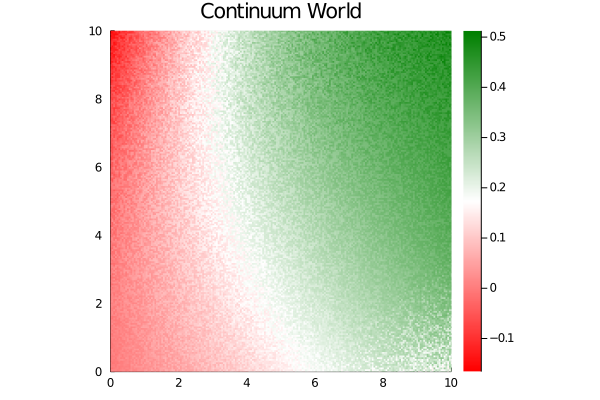

In [314]:
plot(CWorldVis(env.problem, f=s->min(ac.q1(s,ac(s))[],ac.q2(s,ac(s))[])))

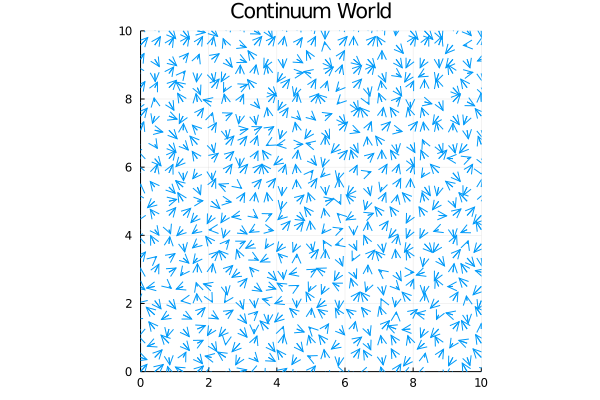

In [315]:
plot(CWorldVis(env.problem, fq=s->0.25.*ac(s)))

In [316]:
t1 = now()
o, ep_ret, ep_len = reset!(env), 0, 0
println("Total steps=$(total_steps)")
scores = []
plts = []
alpha = [1.0]
for t = 1:total_steps    
    if t > start_steps
        a = ac(o)
    else
        a = rand(env.rng, POMDPs.actions(env))
    end
    
    #step the env
    o2, r, d, _ = step!(env, a)
    ep_ret += r
    ep_len += 1
    
    # Ignore done signal if comes from hitting time horizon
    d = (ep_len == max_ep_len) ? false : d
    
    store!(replay_buffer, o, a, r, o2, d)
    
    #very important and easy to miss!
    o = o2
    
    #End of trajectory handling
    if d || (ep_len == max_ep_len)
        #logger.store(EpRet=ep_ret, EpLen=ep_len)
        o, ep_ret, ep_len = reset!(env), 0, 0
    end
    
    #Update handling
    if t >= update_after && mod(t,update_every) == 0
        println("updating (t=$t)")
        flush(stdout)
        for j = 1:update_every*update_ratio
            batch = sample_batch(replay_buffer, batch_size)
            update(ac, ac_targ, batch, q_optimizer, pi_optimizer, polyak, gamma, alpha_optimizer, alpha, target_entropy)
        end
    end
    
    # End of epoch handling
    if (t+1) % steps_per_epoch == 0
        epoch = (t+1) // steps_per_epoch
        
        #save model
        #p = plot(CWorldVis(env.problem, f=s->min(ac.q1(s,ac(s))[],ac.q2(s,ac(s))[])))
        #push!(plts, p)
        @show mean(mean.(Flux.params([ac.q1.q,ac.q2.q])))
        @show mean(mean.(Flux.params([ac.pi.net,ac.pi.mu_layer,ac.pi.log_std_layer])))
        
        #test_agent()
        score = test_agent(ac, test_env, num_test_episodes)
        @show score
        @show alpha[]
        push!(scores, score)
        # Log info about epoch
    end
end

Total steps=40000
mean(mean.(Flux.params([ac.q1.q, ac.q2.q]))) = 0.0009886955f0
mean(mean.(Flux.params([ac.pi.net, ac.pi.mu_layer, ac.pi.log_std_layer]))) = 0.0019226667f0
score = -0.165
alpha[] = 1.0
updating (t=350)
mean(mean.(Flux.params([ac.q1.q, ac.q2.q]))) = -0.00021056627f0
mean(mean.(Flux.params([ac.pi.net, ac.pi.mu_layer, ac.pi.log_std_layer]))) = 0.00084299326f0
score = 0.325
alpha[] = 0.9495703892973227
updating (t=400)
updating (t=450)
updating (t=500)
updating (t=550)
mean(mean.(Flux.params([ac.q1.q, ac.q2.q]))) = 0.0004773811f0
mean(mean.(Flux.params([ac.pi.net, ac.pi.mu_layer, ac.pi.log_std_layer]))) = 0.0006409051f0
score = -0.83
alpha[] = 0.7490640207427581
updating (t=600)
updating (t=650)
updating (t=700)
updating (t=750)
mean(mean.(Flux.params([ac.q1.q, ac.q2.q]))) = 0.000887992f0
mean(mean.(Flux.params([ac.pi.net, ac.pi.mu_layer, ac.pi.log_std_layer]))) = -0.00021051308f0
score = -0.565
alpha[] = 0.5525636772673138
updating (t=800)
updating (t=850)
updating (t=900)

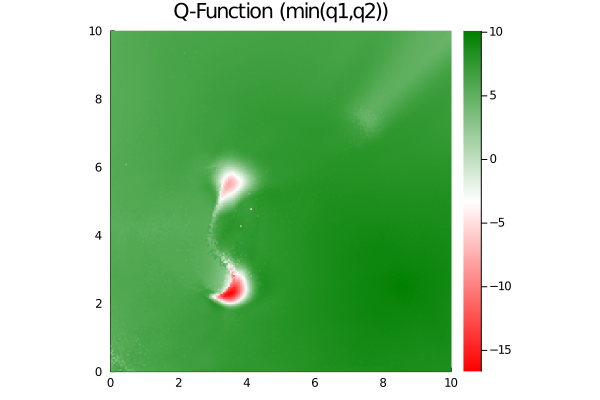

In [317]:
plot(CWorldVis(env.problem, f=s->min(ac.q1(s,ac(s))[],ac.q2(s,ac(s))[])), title="Q-Function (min(q1,q2))")

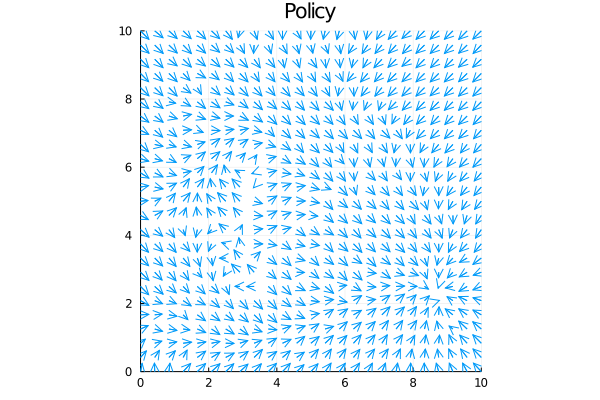

In [318]:
plot(CWorldVis(env.problem, fq=s->0.25.*ac(s)), title="Policy")

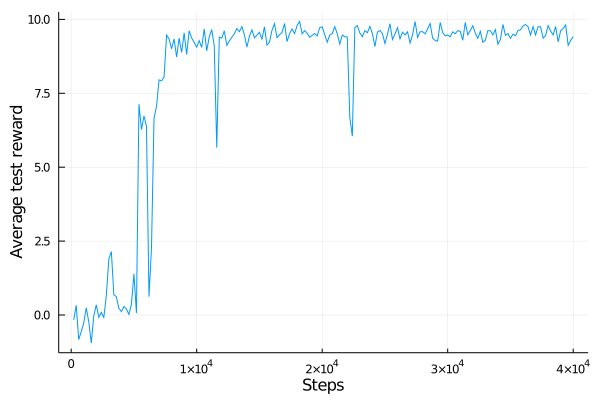

In [319]:
plot([i*steps_per_epoch for i=1:length(scores)], scores, ylabel="Average test reward", xlabel="Steps", legend=false)

In [320]:
#states in replay buffer
p = scatter(replay_buffer.obs_buf[1,1:replay_buffer.size], replay_buffer.obs_buf[2,1:replay_buffer.size], markersize=1, xlim=env.problem.xlim, ylim=env.problem.ylim,legend=false, title="Replay Buffer States")

In [321]:
canonicalize(Dates.CompoundPeriod(now()-t1))

34 minutes, 10 seconds, 940 milliseconds

In [ ]:
data = sample_batch(replay_buffer, batch_size)

In [ ]:
ids = findall(x->x!=0,data.rew)

In [ ]:
data.rew[ids]

In [ ]:
data.obs[:,ids]

In [ ]:
data.obs2[:,ids]

In [ ]:
data.done[ids]

## Initial state distribution

In [ ]:
#initial state distribution
state_dist = initialstate(env.problem)
ps = zeros(2,5000)
for i=1:5000
    ps[:,i] = rand(state_dist)
end
scatter(ps[1,:], ps[2,:], markersize=1)

## rollout test

In [ ]:
function rollout(env, ac)
    hist = []
    rew = []
    act = []
    o = reset!(env)
    d = false
    ep_len = 0
    push!(hist, o)
    while !(d || ep_len == max_ep_len)
        ep_len += 1
        a = ac(o, true)
        #a = Vec2(2.0*rand(),360.0*(rand()-0.5))
        o, r, d, _ = step!(env, a)
        d = (ep_len == max_ep_len) ? false : d
        push!(hist, o)
        push!(rew, r)
        push!(act, a)
    end
    hist, rew, act
end

In [ ]:
myenv = MDPEnvironment(CWorld(; stdev=(0.0,0.0)))

In [ ]:
hist, rew, act = rollout(myenv, ac)
length(hist)

In [ ]:
hist

In [ ]:
plot(map(x->x[1],hist), map(x->x[2],hist), xlim=(0,10), ylim=(0,10),marker=:circle)

In [ ]:
sum(rew)

In [ ]:
vs = [sum(rollout(env,ac)[2]) for i=1:1000]
histogram(filter(x->x != 0,vs))

In [ ]:
obs = [1.1 2.2; 3.3 4.4; 5.5 6.6]'

In [ ]:
act = obs

In [ ]:
ac.q1(obs,act)

In [101]:
mu = [-0.1529 -0.2989 -0.3909; -0.1039 -0.1941 -0.3261]

2×3 Array{Float64,2}:
 -0.1529  -0.2989  -0.3909
 -0.1039  -0.1941  -0.3261

In [102]:
std = [1.0843 1.0248 0.9699; 1.0240 1.1695 1.3486]

2×3 Array{Float64,2}:
 1.0843  1.0248  0.9699
 1.024   1.1695  1.3486

In [103]:
pi_action = mu
logp_pi = normal_logpdf(mu, std, pi_action)

3-element Array{Float64,1}:
 -1.9425282105226607
 -2.018950845051829
 -2.10638177814505

In [104]:
logp_pi2 = logp_pi .- dropdims(sum((2*(log(2) .- pi_action .- softplus.(-2 .* pi_action))); dims=1); dims=1)

3-element Array{Float64,1}:
 -1.9084644853404185
 -1.8934684907876729
 -1.8528106135167826

In [105]:
sum((2*(log(2) .- pi_action .- softplus.(-2 .* pi_action))); dims=1)

1×3 Array{Float64,2}:
 -0.0340637  -0.125482  -0.253571

In [106]:
logp_pi

3-element Array{Float64,1}:
 -1.9425282105226607
 -2.018950845051829
 -2.10638177814505

In [107]:
pi_action = tanh.(pi_action)
pi_action = act_mins .+ (act_maxs .- act_mins) .* (pi_action ./ 2 .+ 0.5) #changed: original assumes all actions have the same symmetrical bounds

2×3 Array{Float64,2}:
 -0.15172   -0.290306  -0.372136
 -0.103528  -0.191699  -0.315012

# 2 methods for generic function "swish":
[1] swish(x::AbstractArray, args...) in NNlib at /Users/rlee18/.julia/packages/NNlib/govuO/src/activations.jl:234
[2] swish(x) in NNlib at /Users/rlee18/.julia/packages/NNlib/govuO/src/activations.jl:134

In [ ]:
### TODO:
#done is not type stable
#implement checkpoints

50//3